# Chain

Review - We built a simple graph with nodes, normal edges and conditional edges.

Goals Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state Using chat models in graph nodes Binding tools to our chat model Executing tool calls in graph nodes.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [6]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="gemma2-9b-it")
result=llm.invoke(messages)
result

AIMessage(content="That's a fantastic choice! Orcas, also known as killer whales, are truly magnificent creatures.  \n\nThe best place to see orcas in the US is widely considered to be **the Pacific Northwest, specifically around Washington State**. \n\nHere's why:\n\n* **Resident Orca Populations:** The Salish Sea, which encompasses the waters surrounding Washington state, is home to three distinct resident orca populations: \n    *  **J Pod:**  The most famous, known for being very active and often seen near the San Juan Islands.\n    * **K Pod:**  Also frequently sighted in the San Juan Islands.\n    * **L Pod:**  Often found near the Olympic Peninsula.\n* **Whale Watching Tours:**  Numerous reputable whale watching tours operate from various locations in the San Juan Islands, including Friday Harbor, Anacortes, and Port Townsend. These tours offer a high chance of spotting orcas and provide knowledgeable guides who can share fascinating information.\n* **Abundant Food Sources:** Th

In [7]:
def add(a:int, b:int)-> int:
    """
    Add a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a+b

In [8]:
llm_with_tools=llm.bind_tools([add])

In [10]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_k3y2', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 982, 'total_tokens': 1068, 'completion_time': 0.156363636, 'prompt_time': 0.034402189, 'queue_time': 0.23649851600000002, 'total_time': 0.190765825}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9cb1bf22-dbb8-4d02-83e9-6dc9f1547f3a-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_k3y2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 982, 'output_tokens': 86, 'total_tokens': 1068})

In [11]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_k3y2',
  'type': 'tool_call'}]

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [18]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                HumanMessage(content="I'm looking for information on generative ai.", name="Deepak")
                ]
#New message to add
new_message= AIMessage(content="Sure, I can help with that. What specific are you interested in?", name="Model")
add_messages(initial_message, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7f011627-4af7-4faf-8d21-81b5aeae6e71'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Deepak', id='d5f70da4-1d2b-4d1e-b96c-6aebdc203f1e'),
 AIMessage(content='Sure, I can help with that. What specific are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='ad793935-b3b2-4a60-a022-e0a2e1d82ec1')]

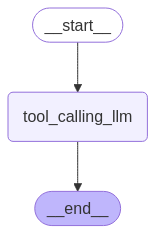

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

#Node
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))